# We will build RNN for Stocks/Crypto price tracking

In [1]:
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
import yfinance as yf

In [3]:
hdfc = yf.download(tickers=["HDFCBANK.NS"], start="2022-01-02", interval='1d')
hdfc

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,HDFCBANK.NS,HDFCBANK.NS,HDFCBANK.NS,HDFCBANK.NS,HDFCBANK.NS
Date,,,,,
2022-01-03,1465.145264,1468.375087,1427.399420,1431.738020,4534592
2022-01-04,1473.726074,1477.920031,1453.720307,1465.482687,4428676
2022-01-05,1508.724121,1515.617698,1473.292219,1481.680250,7166319
2022-01-06,1484.524292,1498.986292,1475.172246,1487.657725,4814465
2022-01-07,1494.937012,1510.555925,1480.812435,1488.621891,5589692
...,...,...,...,...,...
2025-05-21,1926.800049,1946.900024,1921.099976,1927.000000,7566020
2025-05-22,1919.900024,1924.199951,1905.199951,1915.199951,10653335


In [4]:
df = hdfc['Close'].reset_index()
df.columns = ['date', 'Close']
df['Close'] = df['Close'].round(2)

df

,date,Close
0,2022-01-03,1465.15
1,2022-01-04,1473.73
2,2022-01-05,1508.72
3,2022-01-06,1484.52
4,2022-01-07,1494.94
...,...,...
833,2025-05-21,1926.80
834,2025-05-22,1919.90
835,2025-05-23,1933.60
836,2025-05-26,1940.20


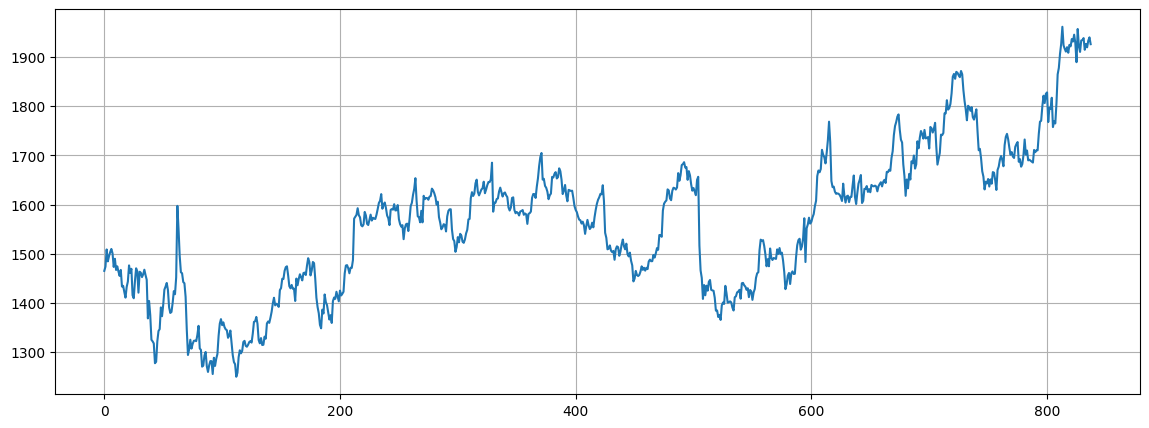

In [5]:
plt.figure(figsize=(14, 5))
plt.plot(df['Close'])

plt.grid('on')
plt.show()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    838 non-null    datetime64[ns]
 1   Close   838 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 13.2 KB


In [7]:
level = int(len(df)*0.8)

train = df[:level]['Close'].values.reshape(-1, 1)
test = df[level:]['Close'].values.reshape(-1, 1)

train.shape, test.shape

((670, 1), (168, 1))

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)

train_scaled.shape, train_scaled

((670, 1),
 array([[0.41515397],
        [0.43168767],
        [0.49911358],
        [0.45248006],
        [0.47255945],
        [0.48853432],
        [0.50107912],
        [0.48389024],
        [0.43066636],
        [0.46251975],
        [0.41858404],
        [0.43297876],
        [0.41291864],
        [0.39536363],
        [0.41877674],
        [0.35383667],
        [0.35643812],
        [0.33210005],
        [0.31036343],
        [0.35206382],
        [0.37306818],
        [0.43660153],
        [0.4071569 ],
        [0.42322812],
        [0.3194589 ],
        [0.30776198],
        [0.37418584],
        [0.42527074],
        [0.4136509 ],
        [0.32976837],
        [0.41170463],
        [0.40790843],
        [0.39071954],
        [0.40158785],
        [0.4197017 ],
        [0.39852391],
        [0.38031372],
        [0.22888966],
        [0.2970671 ],
        [0.24162716],
        [0.14500713],
        [0.1389756 ],
        [0.1306124 ],
        [0.05312753],
        [0.05871584],

In [9]:
test_scaled = scaler.transform(test)
test_scaled.shape, test_scaled

((168, 1),
 array([[0.94710371],
        [0.98294601],
        [0.9988438 ],
        [1.0201372 ],
        [1.02851967],
        [0.96916792],
        [0.92947162],
        [0.91819864],
        [0.83302501],
        [0.78610244],
        [0.70931129],
        [0.77338421],
        [0.73889082],
        [0.79525571],
        [0.77328786],
        [0.84477974],
        [0.83707172],
        [0.8673257 ],
        [0.81597102],
        [0.83273596],
        [0.92301615],
        [0.89574903],
        [0.93669788],
        [0.9633869 ],
        [0.95134312],
        [0.93361468],
        [0.96762632],
        [0.93438548],
        [0.93650518],
        [0.93958839],
        [0.89488187],
        [0.97918835],
        [0.97417813],
        [0.95741319],
        [0.97263653],
        [0.99547154],
        [0.9027826 ],
        [0.83177246],
        [0.85374032],
        [0.87753883],
        [0.94912707],
        [0.94710371],
        [0.95558253],
        [1.03266274],
        [1.03256639],

In [10]:
X_train = []
y_train = []

seq_length=50
for i in range(len(train_scaled)-seq_length):
    X_train.append(train_scaled[i:i+seq_length])
    y_train.append(train_scaled[i+seq_length])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_train, y_train

(array([[[0.41515397],
         [0.43168767],
         [0.49911358],
         ...,
         [0.18690022],
         [0.27190041],
         [0.23744556]],
 
        [[0.43168767],
         [0.49911358],
         [0.45248006],
         ...,
         [0.27190041],
         [0.23744556],
         [0.28230624]],
 
        [[0.49911358],
         [0.45248006],
         [0.47255945],
         ...,
         [0.23744556],
         [0.28230624],
         [0.34158091]],
 
        ...,
 
        [[0.76769954],
         [0.74313023],
         [0.74534628],
         ...,
         [0.80334913],
         [0.80209658],
         [0.81173161]],
 
        [[0.74313023],
         [0.74534628],
         [0.72530543],
         ...,
         [0.80209658],
         [0.81173161],
         [0.80758855]],
 
        [[0.74534628],
         [0.72530543],
         [0.71721201],
         ...,
         [0.81173161],
         [0.80758855],
         [0.85769068]]], shape=(620, 50, 1)),
 array([[0.28230624],
        [0.34

In [11]:
X_test = []
y_test = []

for i in range(len(test_scaled)-seq_length):
    X_test.append(test_scaled[i:i+seq_length])
    y_test.append(test_scaled[i+seq_length])

X_test = np.array(X_test)
y_test = np.array(y_test)
X_test, y_test

(array([[[0.94710371],
         [0.98294601],
         [0.9988438 ],
         ...,
         [1.05279994],
         [1.06946853],
         [1.11109184]],
 
        [[0.98294601],
         [0.9988438 ],
         [1.0201372 ],
         ...,
         [1.06946853],
         [1.11109184],
         [1.17622461]],
 
        [[0.9988438 ],
         [1.0201372 ],
         [1.02851967],
         ...,
         [1.11109184],
         [1.17622461],
         [1.18711219]],
 
        ...,
 
        [[0.85075346],
         [0.8469958 ],
         [0.84362354],
         ...,
         [1.28182449],
         [1.30475585],
         [1.29145951]],
 
        [[0.8469958 ],
         [0.84362354],
         [0.83976953],
         ...,
         [1.30475585],
         [1.29145951],
         [1.31785948]],
 
        [[0.84362354],
         [0.83976953],
         [0.88919721],
         ...,
         [1.29145951],
         [1.31785948],
         [1.33057772]]], shape=(118, 50, 1)),
 array([[1.17622461],
        [1.18

In [12]:
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train.squeeze())
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test.squeeze())


X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([620, 50, 1]),
 torch.Size([620]),
 torch.Size([118, 50, 1]),
 torch.Size([118]))

In [13]:
from torch.utils.data import Dataset, DataLoader

In [14]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [15]:
train_dataset = StockDataset(X=X_train, y=y_train)
test_dataset = StockDataset(X=X_test, y=y_test)
train_dataset, test_dataset

(<__main__.StockDataset at 0x14e2c9a90>,
 <__main__.StockDataset at 0x14e2d5090>)

In [16]:
len(train_dataset), train_dataset[0]

(620,
 (tensor([[0.4152],
          [0.4317],
          [0.4991],
          [0.4525],
          [0.4726],
          [0.4885],
          [0.5011],
          [0.4839],
          [0.4307],
          [0.4625],
          [0.4186],
          [0.4330],
          [0.4129],
          [0.3954],
          [0.4188],
          [0.3538],
          [0.3564],
          [0.3321],
          [0.3104],
          [0.3521],
          [0.3731],
          [0.4366],
          [0.4072],
          [0.4232],
          [0.3195],
          [0.3078],
          [0.3742],
          [0.4253],
          [0.4137],
          [0.3298],
          [0.4117],
          [0.4079],
          [0.3907],
          [0.4016],
          [0.4197],
          [0.3985],
          [0.3803],
          [0.2289],
          [0.2971],
          [0.2416],
          [0.1450],
          [0.1390],
          [0.1306],
          [0.0531],
          [0.0587],
          [0.1392],
          [0.1793],
          [0.1869],
          [0.2719],
          [0.2

In [17]:
len(test_dataset), test_dataset[0]

(118,
 (tensor([[0.9471],
          [0.9829],
          [0.9988],
          [1.0201],
          [1.0285],
          [0.9692],
          [0.9295],
          [0.9182],
          [0.8330],
          [0.7861],
          [0.7093],
          [0.7734],
          [0.7389],
          [0.7953],
          [0.7733],
          [0.8448],
          [0.8371],
          [0.8673],
          [0.8160],
          [0.8327],
          [0.9230],
          [0.8957],
          [0.9367],
          [0.9634],
          [0.9513],
          [0.9336],
          [0.9676],
          [0.9344],
          [0.9365],
          [0.9396],
          [0.8949],
          [0.9792],
          [0.9742],
          [0.9574],
          [0.9726],
          [0.9955],
          [0.9028],
          [0.8318],
          [0.8537],
          [0.8775],
          [0.9491],
          [0.9471],
          [0.9556],
          [1.0327],
          [1.0326],
          [1.0841],
          [1.0472],
          [1.0528],
          [1.0695],
          [1.1

In [18]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x14e2c9be0>,
 <torch.utils.data.dataloader.DataLoader at 0x14e2d5d10>)

In [19]:
for batch in test_dataloader:
    print(batch)
    break

[tensor([[[0.9471],
         [0.9829],
         [0.9988],
         [1.0201],
         [1.0285],
         [0.9692],
         [0.9295],
         [0.9182],
         [0.8330],
         [0.7861],
         [0.7093],
         [0.7734],
         [0.7389],
         [0.7953],
         [0.7733],
         [0.8448],
         [0.8371],
         [0.8673],
         [0.8160],
         [0.8327],
         [0.9230],
         [0.8957],
         [0.9367],
         [0.9634],
         [0.9513],
         [0.9336],
         [0.9676],
         [0.9344],
         [0.9365],
         [0.9396],
         [0.8949],
         [0.9792],
         [0.9742],
         [0.9574],
         [0.9726],
         [0.9955],
         [0.9028],
         [0.8318],
         [0.8537],
         [0.8775],
         [0.9491],
         [0.9471],
         [0.9556],
         [1.0327],
         [1.0326],
         [1.0841],
         [1.0472],
         [1.0528],
         [1.0695],
         [1.1111]],

        [[0.9829],
         [0.9988],
         

In [20]:
for batch in train_dataloader:
    print(batch)
    break

[tensor([[[0.3564],
         [0.3321],
         [0.3104],
         ...,
         [0.5798],
         [0.4731],
         [0.4098]],

        [[0.6157],
         [0.6691],
         [0.6819],
         ...,
         [0.5378],
         [0.5618],
         [0.5761]],

        [[0.5399],
         [0.5320],
         [0.4898],
         ...,
         [0.6635],
         [0.6517],
         [0.6635]],

        ...,

        [[0.8896],
         [0.8706],
         [0.8603],
         ...,
         [0.7269],
         [0.7470],
         [0.7556]],

        [[0.4806],
         [0.4864],
         [0.4551],
         ...,
         [0.7172],
         [0.7188],
         [0.7176]],

        [[0.5558],
         [0.5552],
         [0.5487],
         ...,
         [0.3102],
         [0.2591],
         [0.2601]]]), tensor([0.4058, 0.6169, 0.7010, 0.3358, 0.7719, 0.6961, 0.4978, 0.3987, 0.7340,
        0.1899, 0.3416, 0.4098, 0.1214, 0.1396, 0.7295, 0.7181, 0.5535, 0.7035,
        0.7461, 0.7116, 0.1312, 0.3873, 0.15

In [21]:
batch[0].shape, batch[1].shape

(torch.Size([32, 50, 1]), torch.Size([32]))

In [22]:
for batch in test_dataloader:
    print(batch)
    break

[tensor([[[0.9471],
         [0.9829],
         [0.9988],
         [1.0201],
         [1.0285],
         [0.9692],
         [0.9295],
         [0.9182],
         [0.8330],
         [0.7861],
         [0.7093],
         [0.7734],
         [0.7389],
         [0.7953],
         [0.7733],
         [0.8448],
         [0.8371],
         [0.8673],
         [0.8160],
         [0.8327],
         [0.9230],
         [0.8957],
         [0.9367],
         [0.9634],
         [0.9513],
         [0.9336],
         [0.9676],
         [0.9344],
         [0.9365],
         [0.9396],
         [0.8949],
         [0.9792],
         [0.9742],
         [0.9574],
         [0.9726],
         [0.9955],
         [0.9028],
         [0.8318],
         [0.8537],
         [0.8775],
         [0.9491],
         [0.9471],
         [0.9556],
         [1.0327],
         [1.0326],
         [1.0841],
         [1.0472],
         [1.0528],
         [1.0695],
         [1.1111]],

        [[0.9829],
         [0.9988],
         

In [23]:
batch[0].shape, batch[1].shape

(torch.Size([16, 50, 1]), torch.Size([16]))

In [24]:
len(train_dataloader), len(test_dataloader)

(20, 8)

Now our dataset is ready for RNN/LSTM models

In [25]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

device

'mps'

In [26]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, nonlinearity, dropout, bidirectional):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, nonlinearity=nonlinearity, dropout=dropout, bidirectional=bidirectional, batch_first=True)
        self.linear = nn.Linear(in_features=hidden_size, out_features=output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output, h = self.rnn(x) # output: (batch, seq_len, hidden_size)
        output = self.linear(output[:, -1, :]) # passing only last value of hidden layer for each batch (h_n value), we can also pass mean etch for all sequences too
        return output
    
simpleRNN = SimpleRNN(input_size=1, output_size=1, hidden_size=64, num_layers=1, nonlinearity="tanh", dropout=0, bidirectional=False)
simpleRNN.to(device=device)

simpleRNN, next(simpleRNN.parameters()).device, sum(torch.numel(i) for i in simpleRNN.parameters() if i.requires_grad), simpleRNN.state_dict()

(SimpleRNN(
   (rnn): RNN(1, 64, batch_first=True)
   (linear): Linear(in_features=64, out_features=1, bias=True)
 ),
 device(type='mps', index=0),
 4353,
 OrderedDict([('rnn.weight_ih_l0',
               tensor([[ 1.8472e-02],
                       [-9.7440e-02],
                       [ 1.6310e-02],
                       [ 8.0589e-02],
                       [-6.5931e-02],
                       [ 6.5978e-02],
                       [-8.7175e-02],
                       [ 5.7520e-02],
                       [ 1.3581e-03],
                       [ 1.6684e-03],
                       [ 1.2493e-01],
                       [-3.5873e-02],
                       [-8.1912e-02],
                       [-6.5098e-02],
                       [-9.1795e-02],
                       [ 5.3782e-02],
                       [ 7.7063e-02],
                       [-3.7453e-02],
                       [-1.1264e-01],
                       [ 7.9495e-02],
                       [-6.0511e-02],
            

In [27]:
epochs = 100

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=simpleRNN.parameters(), lr=1e-3)
train_loss = []
test_loss = []

for epoch in range(epochs):
    epoch_loss = 0
    epoch_test_loss = 0

    simpleRNN.train()
    for batch, (X, y) in enumerate(train_dataloader):
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        preds = simpleRNN(X)
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_dataloader)
    train_loss.append(epoch_loss)

    simpleRNN.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X = X.to(device=device)
            y = y.to(device=device)

            preds_test = simpleRNN(X)
            loss_test = loss_fn(preds_test, y)
            epoch_test_loss += loss_test.item()
        epoch_test_loss /= len(test_dataloader)
        test_loss.append(epoch_test_loss)

    if epoch%10==0:
        print(f"Epoch: {epoch}, Train Loss: {epoch_loss}, Test Loss: {epoch_test_loss}")


Epoch: 0, Train Loss: 0.15419851131737233, Test Loss: 0.23689331393688917
Epoch: 10, Train Loss: 0.04764998601749539, Test Loss: 0.32437099050730467
Epoch: 20, Train Loss: 0.047001471556723115, Test Loss: 0.3284571021795273
Epoch: 30, Train Loss: 0.046628352254629135, Test Loss: 0.31572516076266766
Epoch: 40, Train Loss: 0.04613437298685312, Test Loss: 0.3029094683006406
Epoch: 50, Train Loss: 0.046060658432543276, Test Loss: 0.3146871067583561
Epoch: 60, Train Loss: 0.04708067011088133, Test Loss: 0.30412709433585405
Epoch: 70, Train Loss: 0.046372166462242605, Test Loss: 0.2632201323285699
Epoch: 80, Train Loss: 0.04585745017975569, Test Loss: 0.31401985604315996
Epoch: 90, Train Loss: 0.046134463883936404, Test Loss: 0.29133692011237144


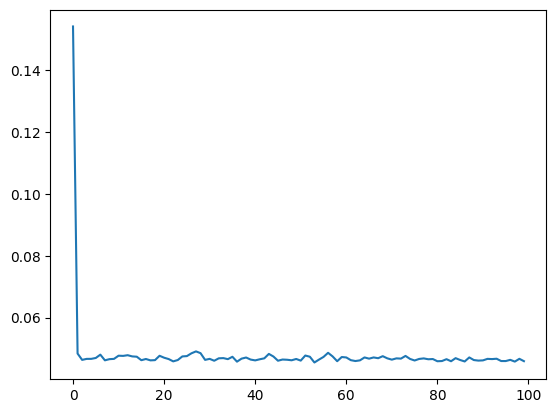

In [28]:
plt.plot(train_loss)

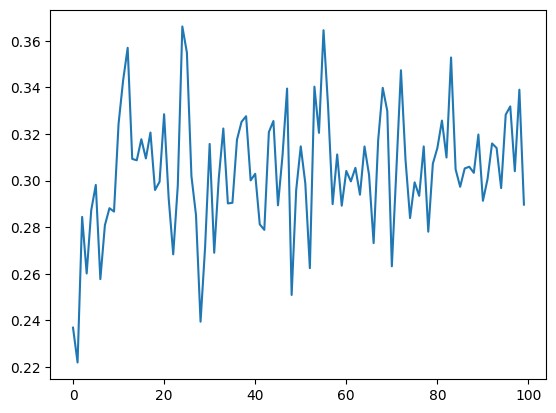

In [29]:
plt.plot(test_loss)

In [30]:
outputs = []
truths = []

simpleRNN.eval()
with torch.no_grad():
    for X, y in test_dataloader:
        preds = simpleRNN(X.to(device))
        outputs += preds.cpu()
        truths += y.cpu()

outputs = [i.item() for i in outputs]
outputs, truths

([0.5520517826080322,
  0.5551824569702148,
  0.5551514029502869,
  0.5532245635986328,
  0.5532749891281128,
  0.5534051060676575,
  0.553465723991394,
  0.5529317855834961,
  0.5535622239112854,
  0.5536046028137207,
  0.5510654449462891,
  0.5486119985580444,
  0.547433614730835,
  0.5469295978546143,
  0.5500855445861816,
  0.5507177114486694,
  0.5498758554458618,
  0.5497127771377563,
  0.5478875637054443,
  0.5477458834648132,
  0.5487534999847412,
  0.5500430464744568,
  0.5468786954879761,
  0.5425397753715515,
  0.5424887537956238,
  0.5428891181945801,
  0.5420849919319153,
  0.5406951904296875,
  0.538535475730896,
  0.5406080484390259,
  0.5415031909942627,
  0.542183518409729,
  0.5406985878944397,
  0.5411121845245361,
  0.5409737229347229,
  0.5428526401519775,
  0.5430898666381836,
  0.5412778854370117,
  0.539112389087677,
  0.5421107411384583,
  0.5443379282951355,
  0.5455783605575562,
  0.5450777411460876,
  0.5433764457702637,
  0.5423663258552551,
  0.54574608802

In [31]:
otp = pd.DataFrame(outputs)
otp['nn'] = truths

otp.columns = ['outputs', 'actual']
otp

,outputs,actual
0,0.552052,tensor(1.1762)
1,0.555182,tensor(1.1871)
2,0.555151,tensor(1.1680)
3,0.553225,tensor(1.1953)
4,0.553275,tensor(1.1916)
...,...,...
113,0.555919,tensor(1.3048)
114,0.555724,tensor(1.2915)
115,0.555943,tensor(1.3179)
116,0.557477,tensor(1.3306)


[]

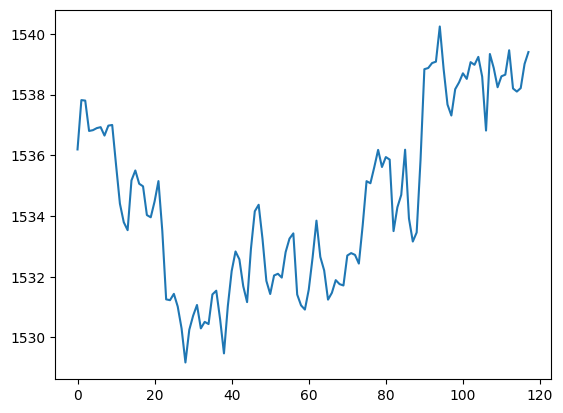

In [32]:
plt.plot(scaler.inverse_transform(otp)[:, 0])

plt.plot()

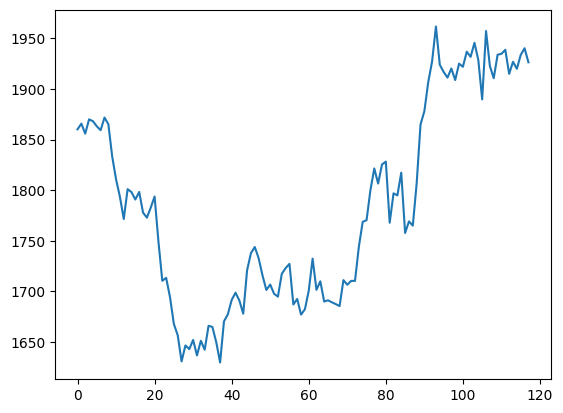

In [33]:
plt.plot(scaler.inverse_transform(otp)[:, 1])


Probably we need a better model

## Stacked RNN

In [34]:
class StackedRNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, nonlinearity, dropout, bidirectional):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, nonlinearity=nonlinearity, dropout=dropout, bidirectional=bidirectional, batch_first=True)
        self.linear = nn.Linear(in_features=hidden_size, out_features=output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output, h = self.rnn(x) # output: (batch, seq_len, hidden_size)
        output = self.linear(output[:, -1, :]) # passing only last value of hidden layer for each batch (h_n value), we can also pass mean etch for all sequences too
        return output
    
stackedRNN = StackedRNN(input_size=1, output_size=1, hidden_size=64, num_layers=3, nonlinearity="tanh", dropout=0, bidirectional=False)
stackedRNN.to(device=device)

stackedRNN, next(stackedRNN.parameters()).device, sum(torch.numel(i) for i in stackedRNN.parameters() if i.requires_grad), stackedRNN.state_dict()

(StackedRNN(
   (rnn): RNN(1, 64, num_layers=3, batch_first=True)
   (linear): Linear(in_features=64, out_features=1, bias=True)
 ),
 device(type='mps', index=0),
 20993,
 OrderedDict([('rnn.weight_ih_l0',
               tensor([[-6.7446e-02],
                       [ 3.7636e-02],
                       [-6.9297e-02],
                       [-6.2195e-02],
                       [ 7.8852e-02],
                       [ 8.7902e-02],
                       [-1.0667e-01],
                       [-2.4169e-02],
                       [-1.2356e-01],
                       [ 9.9227e-02],
                       [ 6.2597e-02],
                       [ 2.7270e-02],
                       [ 1.1064e-01],
                       [-1.6719e-02],
                       [-4.9907e-02],
                       [-9.7174e-02],
                       [ 1.3712e-02],
                       [ 9.4013e-02],
                       [-1.1719e-01],
                       [-4.8881e-02],
                       [ 3.6081e-0

In [35]:
epochs = 100

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=stackedRNN.parameters(), lr=3e-3)
train_loss = []
test_loss = []

for epoch in range(epochs):
    epoch_loss = 0
    epoch_test_loss = 0

    stackedRNN.train()
    for batch, (X, y) in enumerate(train_dataloader):
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        preds = stackedRNN(X)
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_dataloader)
    train_loss.append(epoch_loss)

    stackedRNN.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X = X.to(device=device)
            y = y.to(device=device)

            preds_test = stackedRNN(X)
            loss_test = loss_fn(preds_test, y)
            epoch_test_loss += loss_test.item()
        epoch_test_loss /= len(test_dataloader)
        test_loss.append(epoch_test_loss)

    if epoch%10==0:
        print(f"Epoch: {epoch}, Train Loss: {epoch_loss}, Test Loss: {epoch_test_loss}")


Epoch: 0, Train Loss: 0.06394458292052149, Test Loss: 0.21742548001930118
Epoch: 10, Train Loss: 0.045909315999597314, Test Loss: 0.3547326773405075
Epoch: 20, Train Loss: 0.04656086256727576, Test Loss: 0.30329229310154915
Epoch: 30, Train Loss: 0.04632199387997389, Test Loss: 0.3045998578891158
Epoch: 40, Train Loss: 0.04755100850015879, Test Loss: 0.29294677171856165
Epoch: 50, Train Loss: 0.04683476183563471, Test Loss: 0.2931205239146948
Epoch: 60, Train Loss: 0.04610224300995469, Test Loss: 0.31337958108633757
Epoch: 70, Train Loss: 0.046570129320025445, Test Loss: 0.2990983035415411
Epoch: 80, Train Loss: 0.047794989123940465, Test Loss: 0.32939356565475464
Epoch: 90, Train Loss: 0.046810686495155095, Test Loss: 0.3195805288851261


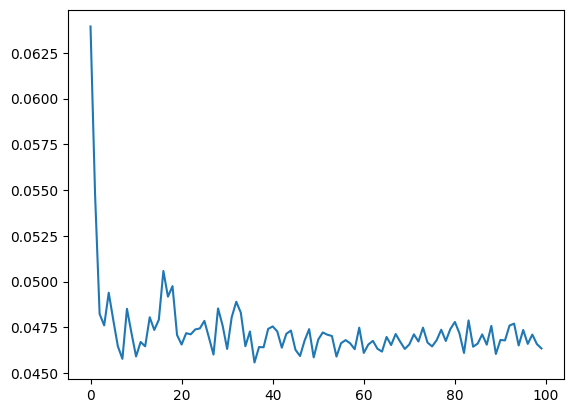

In [36]:
plt.plot(train_loss)

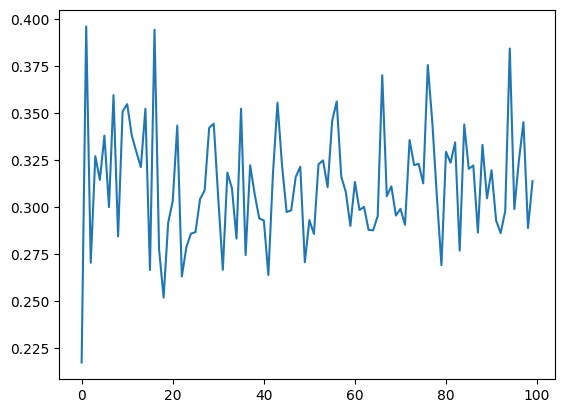

In [37]:
plt.plot(test_loss)

In [38]:
outputs = []
truths = []

stackedRNN.eval()
with torch.no_grad():
    for X, y in test_dataloader:
        preds = stackedRNN(X.to(device))
        outputs += preds.cpu()
        truths += y.cpu()

outputs = [i.item() for i in outputs]
otp = pd.DataFrame(outputs)
otp['nn'] = truths

otp.columns = ['outputs', 'actual']
otp

,outputs,actual
0,0.527886,tensor(1.1762)
1,0.529792,tensor(1.1871)
2,0.529527,tensor(1.1680)
3,0.528940,tensor(1.1953)
4,0.528126,tensor(1.1916)
...,...,...
113,0.530664,tensor(1.3048)
114,0.530508,tensor(1.2915)
115,0.528527,tensor(1.3179)
116,0.530559,tensor(1.3306)


[]

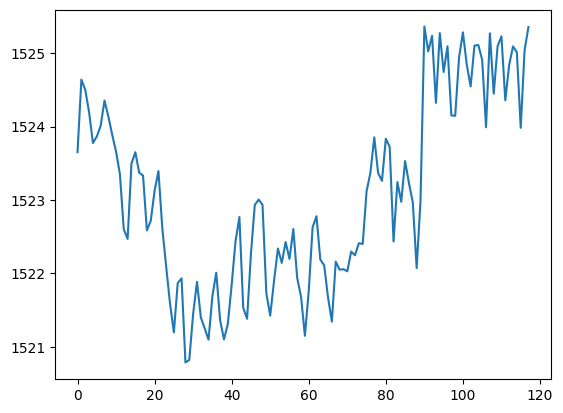

In [39]:
plt.plot(scaler.inverse_transform(otp)[:, 0])

plt.plot()

[]

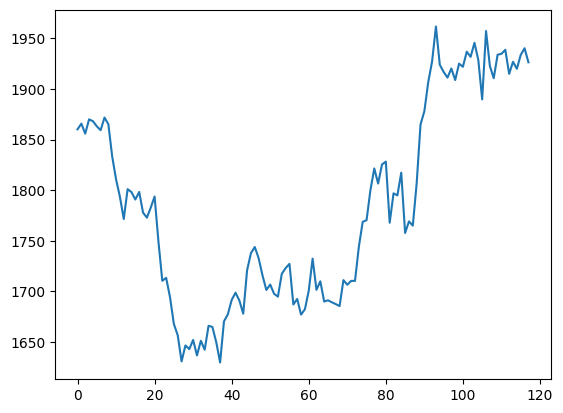

In [40]:
plt.plot(scaler.inverse_transform(otp)[:, 1])

plt.plot()

[]

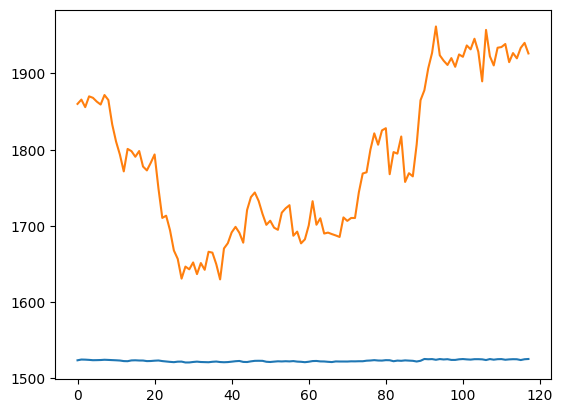

In [41]:
plt.plot(scaler.inverse_transform(otp)[:, 0])
plt.plot(scaler.inverse_transform(otp)[:, 1])

plt.plot()

Building bidirectional stacked RNNs

In [42]:
class BiDirectionalRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout, num_layers):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.linear = nn.Linear(in_features=hidden_size*2, out_features=output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output, h = self.rnn(x)
        return self.linear(output[:, -1, :])
    
bidirRNN = BiDirectionalRNN(input_size=1, output_size=1, hidden_size=64, num_layers=3, dropout=0.2)
bidirRNN.to(device=device)

bidirRNN, next(bidirRNN.parameters()).device, sum(torch.numel(i) for i in bidirRNN.parameters() if i.requires_grad), bidirRNN.state_dict()

(BiDirectionalRNN(
   (rnn): RNN(1, 64, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
   (linear): Linear(in_features=128, out_features=1, bias=True)
 ),
 device(type='mps', index=0),
 58369,
 OrderedDict([('rnn.weight_ih_l0',
               tensor([[-0.0587],
                       [-0.0839],
                       [ 0.0506],
                       [-0.0990],
                       [-0.1052],
                       [-0.1037],
                       [-0.1178],
                       [-0.0298],
                       [ 0.0408],
                       [ 0.0388],
                       [-0.0441],
                       [-0.0122],
                       [ 0.0819],
                       [-0.1007],
                       [-0.0394],
                       [-0.0226],
                       [ 0.0396],
                       [ 0.0532],
                       [-0.0336],
                       [ 0.1147],
                       [ 0.0557],
                       [-0.0936],
      

In [43]:
epochs = 100

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=bidirRNN.parameters(), lr=3e-3)
train_loss = []
test_loss = []

for epoch in range(epochs):
    epoch_loss = 0
    epoch_test_loss = 0

    bidirRNN.train()
    for batch, (X, y) in enumerate(train_dataloader):
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        preds = bidirRNN(X)
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_dataloader)
    train_loss.append(epoch_loss)

    bidirRNN.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X = X.to(device=device)
            y = y.to(device=device)

            preds_test = bidirRNN(X)
            loss_test = loss_fn(preds_test, y)
            epoch_test_loss += loss_test.item()
        epoch_test_loss /= len(test_dataloader)
        test_loss.append(epoch_test_loss)

    if epoch%10==0:
        print(f"Epoch: {epoch}, Train Loss: {epoch_loss}, Test Loss: {epoch_test_loss}")


Epoch: 0, Train Loss: 0.07896339800208807, Test Loss: 0.2620635274797678
Epoch: 10, Train Loss: 0.050427545048296454, Test Loss: 0.2553173154592514
Epoch: 20, Train Loss: 0.04719662284478545, Test Loss: 0.3325670789927244
Epoch: 30, Train Loss: 0.04613046366721392, Test Loss: 0.32858524192124605
Epoch: 40, Train Loss: 0.04619256583973765, Test Loss: 0.31313617527484894
Epoch: 50, Train Loss: 0.04763252940028906, Test Loss: 0.3253747373819351
Epoch: 60, Train Loss: 0.04767457228153944, Test Loss: 0.30663990415632725
Epoch: 70, Train Loss: 0.04612969420850277, Test Loss: 0.2880274159833789
Epoch: 80, Train Loss: 0.04610193902626634, Test Loss: 0.34153795056045055
Epoch: 90, Train Loss: 0.04691161485388875, Test Loss: 0.29708283953368664


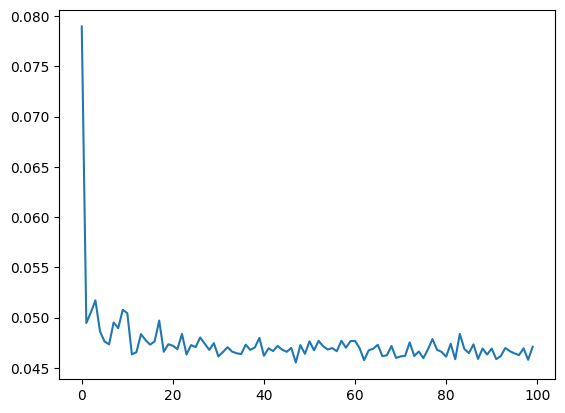

In [44]:
plt.plot(train_loss)

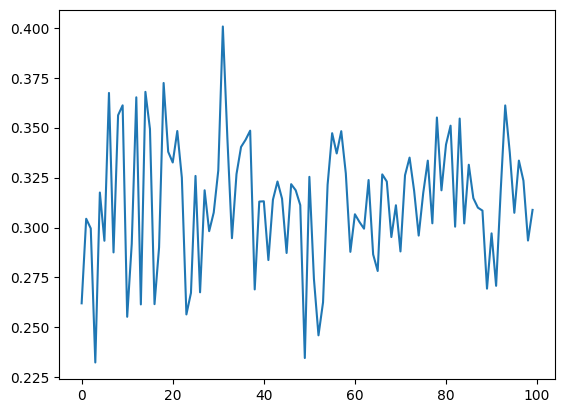

In [45]:
plt.plot(test_loss)

In [46]:
outputs = []
truths = []

bidirRNN.eval()
with torch.no_grad():
    for X, y in test_dataloader:
        preds = bidirRNN(X.to(device))
        outputs += preds.cpu()
        truths += y.cpu()

outputs = [i.item() for i in outputs]
otp = pd.DataFrame(outputs)
otp['nn'] = truths

otp.columns = ['outputs', 'actual']
otp

,outputs,actual
0,0.532642,tensor(1.1762)
1,0.534273,tensor(1.1871)
2,0.534105,tensor(1.1680)
3,0.533597,tensor(1.1953)
4,0.534667,tensor(1.1916)
...,...,...
113,0.536051,tensor(1.3048)
114,0.536562,tensor(1.2915)
115,0.536527,tensor(1.3179)
116,0.536823,tensor(1.3306)


[]

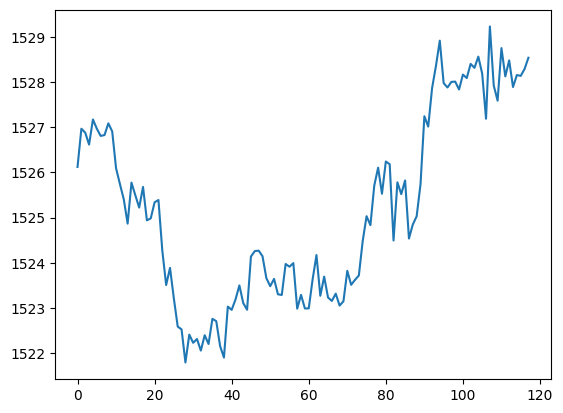

In [48]:
plt.plot(scaler.inverse_transform(otp)[:, 0])

plt.plot()

[]

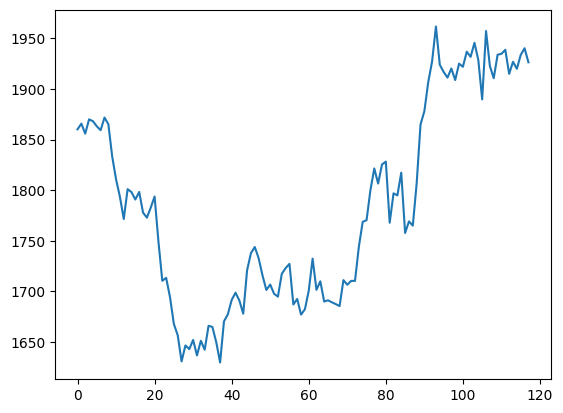

In [49]:
plt.plot(scaler.inverse_transform(otp)[:, 1])

plt.plot()

Looks like we aren't making that good model. Let's try a custom model with
- Dropout layers
- Self attention layers
- Batch normal layers
- Residual layers

In [50]:
class SelfAttention(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.input_size = input_size
        self.query = nn.Linear(input_size, input_size)
        self.key = nn.Linear(input_size, input_size)
        self.value = nn.Linear(input_size, input_size)

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        output_first = (Q @ K.transpose(2, 1))/(self.input_size**0.5)
        softmax_output = torch.softmax(output_first, dim=2)
        output_last = softmax_output@V

        return output_last

class CustomModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_layers=None, attention_layers=None, batchnorm_layers=None, residual_layers=None):
        super().__init__()
        self.output_size = output_size

        self.rnn_layers = nn.ModuleList()
        self.dropouts = nn.ModuleDict()
        self.attentions = nn.ModuleDict()
        self.batchnorms = nn.ModuleDict()

        for i in range(num_layers):
            size = input_size if i==0 else hidden_size*2
            self.rnn_layers.append(
                nn.RNN(input_size=size, hidden_size=hidden_size, num_layers=1, batch_first=True, bidirectional=True)
            )
            
            if dropout_layers and i in dropout_layers:
                self.dropouts[str(i)] = nn.Dropout(p=0.3)
            
            if batchnorm_layers and i in batchnorm_layers:
                self.batchnorms[str(i)] = nn.BatchNorm1d(num_features=hidden_size*2)

            if attention_layers and i in attention_layers:
                self.attentions[str(i)] = SelfAttention(hidden_size*2)

        self.linear = nn.Linear(in_features=hidden_size*2, out_features=output_size)
        self.residual_layers = residual_layers if residual_layers else []

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for i, rnn in enumerate(self.rnn_layers):
            output, hn = rnn(x)
            if str(i) in self.attentions:
                output = self.attentions[str(i)](output)

            if str(i) in self.batchnorms:
                output = self.batchnorms[str(i)](output.permute(0, 2, 1)).permute(0, 2, 1)

            if str(i) in self.dropouts:
                output = self.dropouts[str(i)](output)

            if i in self.residual_layers and x.shape == output.shape:
                output = output + x
            
            x = output

        return self.linear(x[:, -1, :])
    
model = CustomModel(input_size=1, hidden_size=64, output_size=1, num_layers=4, dropout_layers={0, 1, 2, 3}, attention_layers={0, 1, 2}, batchnorm_layers={2, 3}, residual_layers={1, 3})
model.to(device=device)

model, sum(torch.numel(i) for i in model.parameters() if i.requires_grad), next(model.parameters()).device

(CustomModel(
   (rnn_layers): ModuleList(
     (0): RNN(1, 64, batch_first=True, bidirectional=True)
     (1-3): 3 x RNN(128, 64, batch_first=True, bidirectional=True)
   )
   (dropouts): ModuleDict(
     (0): Dropout(p=0.3, inplace=False)
     (1): Dropout(p=0.3, inplace=False)
     (2): Dropout(p=0.3, inplace=False)
     (3): Dropout(p=0.3, inplace=False)
   )
   (attentions): ModuleDict(
     (0): SelfAttention(
       (query): Linear(in_features=128, out_features=128, bias=True)
       (key): Linear(in_features=128, out_features=128, bias=True)
       (value): Linear(in_features=128, out_features=128, bias=True)
     )
     (1): SelfAttention(
       (query): Linear(in_features=128, out_features=128, bias=True)
       (key): Linear(in_features=128, out_features=128, bias=True)
       (value): Linear(in_features=128, out_features=128, bias=True)
     )
     (2): SelfAttention(
       (query): Linear(in_features=128, out_features=128, bias=True)
       (key): Linear(in_features=128,

In [51]:
from torchinfo import summary
summary(model=model, input_size=(32, 50, 1), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CustomModel                              [32, 50, 1]               [32, 1]                   --
├─ModuleList: 1-11                       --                        --                        (recursive)
│    └─RNN: 2-1                          [32, 50, 1]               [32, 50, 128]             8,576
├─ModuleDict: 1-8                        --                        --                        (recursive)
│    └─SelfAttention: 2-2                [32, 50, 128]             [32, 50, 128]             --
│    │    └─Linear: 3-1                  [32, 50, 128]             [32, 50, 128]             16,512
│    │    └─Linear: 3-2                  [32, 50, 128]             [32, 50, 128]             16,512
│    │    └─Linear: 3-3                  [32, 50, 128]             [32, 50, 128]             16,512
├─ModuleDict: 1-13                       --                        --                        --
│ 

In [52]:
epochs = 100

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-3)
train_loss = []
test_loss = []

model.to(device=device)
for epoch in range(epochs):
    epoch_loss = 0
    epoch_test_loss = 0

    model.train()
    for batch, (X, y) in enumerate(train_dataloader):
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        preds = model(X)
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_dataloader)
    train_loss.append(epoch_loss)

    model.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X = X.to(device=device)
            y = y.to(device=device)

            preds_test = model(X)
            loss_test = loss_fn(preds_test, y)
            epoch_test_loss += loss_test.item()
        epoch_test_loss /= len(test_dataloader)
        test_loss.append(epoch_test_loss)

    if epoch%10==0:
        print(f"Epoch: {epoch}, Train Loss: {epoch_loss}, Test Loss: {epoch_test_loss}")


Epoch: 0, Train Loss: 0.6199766978621483, Test Loss: 0.48806493915617466
Epoch: 10, Train Loss: 0.060164832323789594, Test Loss: 0.3818197622895241
Epoch: 20, Train Loss: 0.05109723471105099, Test Loss: 0.32815844751894474
Epoch: 30, Train Loss: 0.04997760374099016, Test Loss: 0.27641985565423965
Epoch: 40, Train Loss: 0.05341313183307648, Test Loss: 0.18894629087299109
Epoch: 50, Train Loss: 0.04844862390309572, Test Loss: 0.33566855173557997
Epoch: 60, Train Loss: 0.051134264841675756, Test Loss: 0.3589191660284996
Epoch: 70, Train Loss: 0.047979976050555706, Test Loss: 0.30380886513739824
Epoch: 80, Train Loss: 0.04906829297542572, Test Loss: 0.35754695162177086
Epoch: 90, Train Loss: 0.049091674759984015, Test Loss: 0.30375582072883844


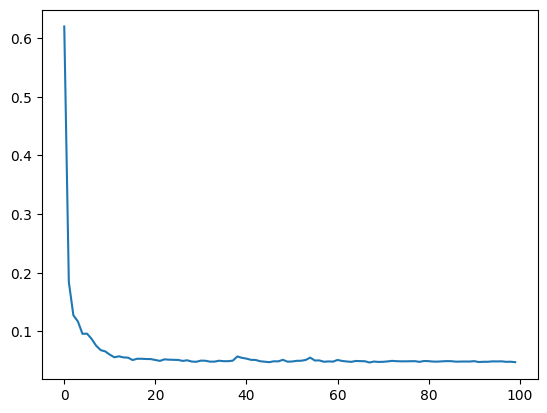

In [53]:
plt.plot(train_loss)

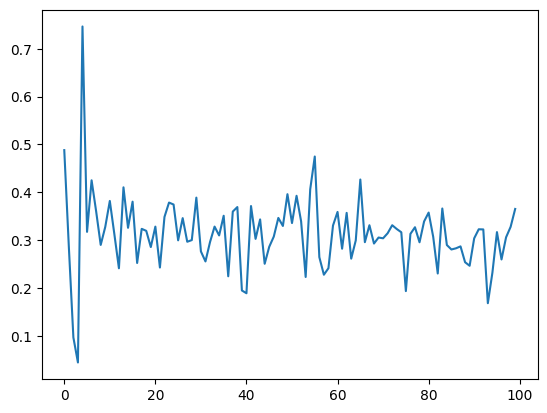

In [54]:
plt.plot(test_loss)

In [55]:
outputs = []
truths = []

model.eval()
with torch.no_grad():
    for X, y in test_dataloader:
        preds = model(X.to(device))
        outputs += preds.cpu()
        truths += y.cpu()

outputs = [i.item() for i in outputs]
otp = pd.DataFrame(outputs)
otp['nn'] = truths

otp.columns = ['outputs', 'actual']
otp

,outputs,actual
0,0.480627,tensor(1.1762)
1,0.480651,tensor(1.1871)
2,0.480670,tensor(1.1680)
3,0.480683,tensor(1.1953)
4,0.480697,tensor(1.1916)
...,...,...
113,0.481825,tensor(1.3048)
114,0.481885,tensor(1.2915)
115,0.481953,tensor(1.3179)
116,0.482028,tensor(1.3306)


[]

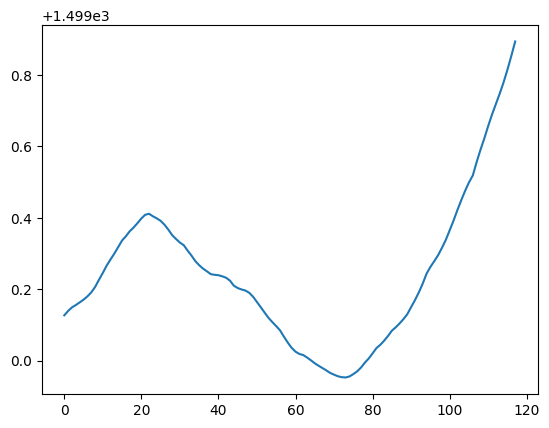

In [56]:
plt.plot(scaler.inverse_transform(otp)[:, 0])

plt.plot()

[]

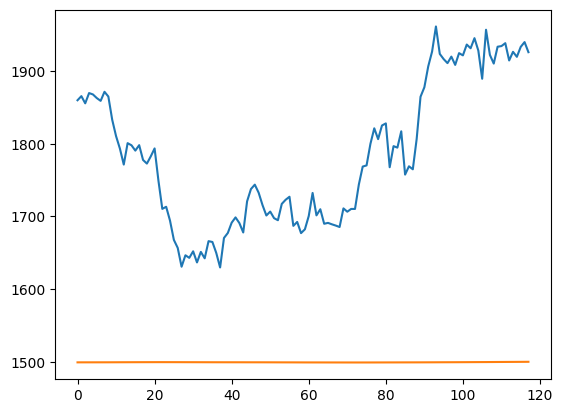

In [58]:
plt.plot(scaler.inverse_transform(otp)[:, 1])
plt.plot(scaler.inverse_transform(otp)[:, 0])

plt.plot()

So, results are not satisfactory and nowhere close near to our real values even on trying complicated models. Let's try LSTMs and multivariate models in our LSTM series.

Tune in for the LSTM models!